In [4]:
import cv2
import numpy as np
from skimage import morphology
import matplotlib.pyplot as plt
from matplotlib import cm  # For colormap
from matplotlib.colors import Normalize
import itertools
import urllib.request
from seaborn import boxplot, histplot, despine
import matplotlib.gridspec as gridspec
from sklearn.decomposition import PCA
from scipy.spatial import distance, KDTree
from tqdm import tqdm
import time
import random
from matplotlib.backends.backend_pdf import PdfPages
from datetime import datetime
import os
import streamlit as st
import tempfile

In [5]:
def anisotropic_diffusion(img, niter=1, kappa=50, gamma=0.1, voxelspacing=None, option=1):
    r"""
    Edge-preserving, XD Anisotropic diffusion.
 
    To achieve the best effects, the image should be scaled to
    values between 0 and 1 beforehand.
 
 
    Parameters
    ----------
    img : array_like
        Input image (will be cast to numpy.float).
    niter : integer
        Number of iterations.
    kappa : integer
        Conduction coefficient, e.g. 20-100. ``kappa`` controls conduction
        as a function of the gradient. If ``kappa`` is low small intensity
        gradients are able to block conduction and hence diffusion across
        steep edges. A large value reduces the influence of intensity gradients
        on conduction.
    gamma : float
        Controls the speed of diffusion. Pick a value :math:`<= .25` for stability.
    voxelspacing : tuple of floats or array_like
        The distance between adjacent pixels in all img.ndim directions
    option : {1, 2, 3}
        Whether to use the Perona Malik diffusion equation No. 1 or No. 2,
        or Tukey's biweight function.
        Equation 1 favours high contrast edges over low contrast ones, while
        equation 2 favours wide regions over smaller ones. See [1]_ for details.
        Equation 3 preserves sharper boundaries than previous formulations and
        improves the automatic stopping of the diffusion. See [2]_ for details.
 
    Returns
    -------
    anisotropic_diffusion : ndarray
        Diffused image.
 
    Notes
    -----
    Original MATLAB code by Peter Kovesi,
    School of Computer Science & Software Engineering,
    The University of Western Australia,
    pk @ csse uwa edu au,
    <http://www.csse.uwa.edu.au>
 
    Translated to Python and optimised by Alistair Muldal,
    Department of Pharmacology,
    University of Oxford,
    <alistair.muldal@pharm.ox.ac.uk>
 
    Adapted to arbitrary dimensionality and added to the MedPy library Oskar Maier,
    Institute for Medical Informatics,
    Universitaet Luebeck,
    <oskar.maier@googlemail.com>
 
    June 2000  original version. -
    March 2002 corrected diffusion eqn No 2. -
    July 2012 translated to Python -
    August 2013 incorporated into MedPy, arbitrary dimensionality -
 
    References
    ----------
    .. [1] P. Perona and J. Malik.
       Scale-space and edge detection using ansotropic diffusion.
       IEEE Transactions on Pattern Analysis and Machine Intelligence,
       12(7):629-639, July 1990.
    .. [2] M.J. Black, G. Sapiro, D. Marimont, D. Heeger
       Robust anisotropic diffusion.
       IEEE Transactions on Image Processing,
       7(3):421-432, March 1998.
    """
    # define conduction gradients functions
    if option == 1:
 
        def condgradient(delta, spacing):
            return np.exp(-((delta / kappa) ** 2.0)) / float(spacing)
 
    elif option == 2:
 
        def condgradient(delta, spacing):
            return 1.0 / (1.0 + (delta / kappa) ** 2.0) / float(spacing)
 
    elif option == 3:
        kappa_s = kappa * (2**0.5)
 
        def condgradient(delta, spacing):
            top = 0.5 * ((1.0 - (delta / kappa_s) ** 2.0) ** 2.0) / float(spacing)
            return np.where(np.abs(delta) <= kappa_s, top, 0)
 
    # initialize output array
    out = np.array(img, dtype=np.float32, copy=True)
 
    # set default voxel spacing if not supplied
    if voxelspacing is None:
        voxelspacing = tuple([1.0] * img.ndim)
 
    # initialize some internal variables
    deltas = [np.zeros_like(out) for _ in range(out.ndim)]
 
    for _ in range(niter):
        # calculate the diffs
        for i in range(out.ndim):
            slicer = tuple(
                [slice(None, -1) if j == i else slice(None) for j in range(out.ndim)]
            )
            deltas[i][tuple(slicer)] = np.diff(out, axis=i)
 
        # update matrices
        matrices = [
            condgradient(delta, spacing) * delta
            for delta, spacing in zip(deltas, voxelspacing)
        ]
 
        # subtract a copy that has been shifted ('Up/North/West' in 3D case) by one
        # pixel. Don't as questions. just do it. trust me.
        for i in range(out.ndim):
            slicer = tuple(
                [slice(1, None) if j == i else slice(None) for j in range(out.ndim)]
            )
            matrices[i][tuple(slicer)] = np.diff(matrices[i], axis=i)
 
        # update the image
        out += gamma * (np.sum(matrices, axis=0))
 
    return out

def skel_unique(img):
    # Main loop for initial pass at skeletonization
    skel = np.zeros(img.shape, np.uint8)                              # Creates blank canvas to store skeletonized image
    element = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))                  # Generates kernel to pass through each section of image
    while True:
        open_img = cv2.morphologyEx(img, cv2.MORPH_OPEN, element)     # Fit open-cross kernel to thresholded image
        temp = cv2.subtract(img, open_img)                            # Subtracts the above from the original image
        temp = temp.astype(skel.dtype)                                            # Convert temp from 32-bit to 8bit datatype
        skel = cv2.bitwise_or(skel, temp)                                         # aggregates and compares both original and above created image
        img = cv2.erode(img, element)                     # degrades the width of the image by 1 pixel
        if cv2.countNonZero(img) == 0:                                # conditional exits if there are no more remaining iterations to pass through
            break
    return skel

def find_tips(skel_img):
    kernel = np.array([[1, 1, 1], [1, 10, 1], [1, 1, 1]], dtype=np.uint8)
    neighbors = cv2.filter2D(skel_img, -1, kernel)
    tips = (neighbors == 11).astype(np.uint8) * 255
    return tips

def merge_close_branch_points(branch_pts, threshold=10):
    """
    Merge branch points that are within a close distance of each other.
    """
    if len(branch_pts) < 2:
        return branch_pts

    merged_points = []
    used = set()

    for i, pt1 in enumerate(branch_pts):
        if i in used:
            continue
        group = [pt1]

        for j, pt2 in enumerate(branch_pts):
            if j != i and np.linalg.norm(pt1 - pt2) < threshold:
                group.append(pt2)
                used.add(j)

        # Take the mean of close points to create a single merged point
        merged_point = np.mean(group, axis=0).astype(np.int32)
        merged_points.append(merged_point)

    return np.array(merged_points)

def cos_sim(vectors):
    smallest_similarity = float('inf')
    smallest_pair = None
    
    # Generate all combinations of two vectors
    for (key1, vec1), (key2, vec2) in itertools.combinations(vectors.items(), 2):
        # Compute cosine similarity as the dot product (vectors are normalized)
        similarity = np.dot(vec1[0], vec2[0])
        
        # Check if this is the smallest similarity so far
        if similarity < smallest_similarity:
            smallest_similarity = similarity
            smallest_pair = (key1, key2)
    
    return smallest_similarity, smallest_pair

class UnionFind:
    def __init__(self):
        self.parent = {}

    def find(self, x):
        if x not in self.parent:
            self.parent[x] = x
        if self.parent[x] != x:
            self.parent[x] = self.find(self.parent[x])  # Path compression
        return self.parent[x]

    def union(self, x, y):
        root_x = self.find(x)
        root_y = self.find(y)
        if root_x != root_y:
            self.parent[root_y] = root_x

def sort_by_proximity(contour_points, branch_point):
    """
    Sorts a list of points (from cv2.findContours) starting from the point closest to the branch point.
    Then it orders the remaining points based on nearest-neighbor proximity.

    Parameters:
        contour_points (numpy.ndarray): Array of points of shape (n, 1, 2) as returned by cv2.findContours.
        branch_point (tuple or np.ndarray): The (x, y) coordinate from which to anchor the sorting.

    Returns:
        numpy.ndarray: Sorted array of points of shape (n, 1, 2) with minimal distance between neighbors,
                       starting from the point closest to the branch point.
    """
    # Reshape contour points to (n, 2) for processing if needed.
    if contour_points.ndim == 3:
        contour_points = contour_points.reshape(-1, 2)

    # Remove duplicate points.
    contour_points = np.unique(contour_points, axis=0)

    # Find the point in the contour closest to the branch point.
    distances_to_branch = np.linalg.norm(contour_points - branch_point, axis=1)
    start_index = np.argmin(distances_to_branch)
    sorted_points = [contour_points[start_index]]
    contour_points = np.delete(contour_points, start_index, axis=0)

    # Greedily add the nearest neighbor.
    while len(contour_points) > 0:
        last_point = sorted_points[-1]
        distances = np.linalg.norm(contour_points - last_point, axis=1)
        nearest_idx = np.argmin(distances)
        sorted_points.append(contour_points[nearest_idx])
        contour_points = np.delete(contour_points, nearest_idx, axis=0)

    # Return the sorted points as an array of shape (n, 1, 2)
    return np.array(sorted_points).reshape(-1, 1, 2)

def sort_points_global(points):
    """
    Sort a set of points in a nearest-neighbor path from one end to the other.
    points: (N, 2) array of [x, y].
    """
    # Remove duplicates
    points = np.unique(points, axis=0)

    # Pick an initial point: e.g., leftmost or topmost
    start_idx = np.argmin(points[:, 0])  # leftmost
    sorted_points = [points[start_idx]]
    points = np.delete(points, start_idx, axis=0)

    # Greedily add nearest neighbor
    while len(points) > 0:
        last = sorted_points[-1]
        dists = np.linalg.norm(points - last, axis=1)
        nn_idx = np.argmin(dists)
        sorted_points.append(points[nn_idx])
        points = np.delete(points, nn_idx, axis=0)

    return np.array(sorted_points)

def adaptive_sort(points):
    """
    Sorts an edge dynamically based on its primary orientation.
    - Uses PCA to determine whether to sort by X or Y.
    """
    points = np.unique(points, axis=0)  # Remove duplicates

    if len(points) < 2:
        return points  # Not enough points to sort

    # Perform PCA to find the principal direction
    pca = PCA(n_components=2)
    pca.fit(points)
    principal_direction = pca.components_[0]  # First principal component

    # Determine whether to sort by X or Y based on the principal direction
    if abs(principal_direction[0]) > abs(principal_direction[1]):
        # More horizontal → sort by X
        sorted_points = points[np.argsort(points[:, 0])]
    else:
        # More vertical → sort by Y
        sorted_points = points[np.argsort(points[:, 1])]

    return sorted_points

def greedy_sort(points):
    points = np.unique(points, axis=0)
    if len(points) == 0:
        return points

    ordered = [points[0]]
    points = np.delete(points, 0, axis=0)

    while len(points):
        dists = distance.cdist([ordered[-1]], points)[0]
        next_idx = np.argmin(dists)
        ordered.append(points[next_idx])
        points = np.delete(points, next_idx, axis=0)

    return np.array(ordered)

def pca_curvature_score(points):
    """
    Returns a curvature score: higher = straighter.
    Uses PCA explained variance ratio.
    """
    if len(points) < 5:
        return 0
    pca = PCA(n_components=2)
    pca.fit(points)
    return pca.explained_variance_ratio_[0]  # how much variance is in the primary direction

class fiberL:
    def __init__(self, image, niter=50, kappa=50, gamma=0.2, thresh_1 = 126, g_blur = 9, thresh_2 = 15, ksize = 5, min_prune = 5, max_node_dist=15):
        self.image = image
        self.niter = niter
        self.kappa = kappa
        self.gamma=gamma
        self.thresh_1 = thresh_1
        self.thresh_2 = thresh_2
        self.g_blur = g_blur
        self.ksize = ksize
        self.min_prune = min_prune
        self.max_node_dist = max_node_dist

    def preproc(self):
        if self.image is not None:
            start = time.time()
            print("🧼 Preprocessing started...")

            if len(self.image.shape) == 3:
                gray_image = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
            else:
                gray_image = self.image.copy()

            print("  ⏳ Running anisotropic diffusion...")
            self.diff_img = anisotropic_diffusion(gray_image, niter=self.niter, kappa=self.kappa, gamma=self.gamma, option=1)
            self.binary_thresh = cv2.threshold(self.diff_img, self.thresh_1, 255, cv2.THRESH_BINARY)[1].astype('uint8')
            self.binary_canny = cv2.Canny((self.diff_img).astype(np.uint8), 20, 60)
            self.binary_image = cv2.bitwise_or(self.binary_thresh, self.binary_canny)
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))  # Try (5, 5) or adjust size
            # Close small gaps
            closed = cv2.morphologyEx(self.binary_image, cv2.MORPH_CLOSE, kernel)
            # Optional: dilate to strengthen weak lines
            closed = cv2.dilate(closed, kernel, iterations=1)
            # Optional: erode to reduce extra thickness
            # closed = cv2.erode(closed, kernel, iterations=1)
            self.binary_image = closed  # update before skeletonization
            self.skel1 = skel_unique(self.binary_image)
            self.blurred_image = cv2.GaussianBlur(self.skel1, (self.g_blur, self.g_blur), 0)
            _, self.final_binary = cv2.threshold(self.blurred_image, self.thresh_2, 255, cv2.THRESH_BINARY)
            self.sk_image = morphology.skeletonize(self.final_binary > 0).astype(np.uint8)

            print(f"✅ Preprocessing completed in {time.time() - start:.2f}s\n")

    def branch(self):
        start = time.time()
        print("🔍 Detecting branches...")

        skel_img = self.sk_image.copy()

        # Define the branch point detection kernels
        t1 = np.array([[-1, 1, -1],
                    [1, 1, 1],
                    [-1, -1, -1]], dtype=np.int8)

        t2 = np.array([[1, -1, 1],
                    [-1, 1, -1],
                    [1, -1, -1]], dtype=np.int8)

        y1 = np.array([[1, -1, 1],
                    [0,  1, 0],
                    [0,  1, 0]], dtype=np.int8)

        y2 = np.array([[-1,  1, -1],
                    [ 1,  1,  0],
                    [-1,  0,  1]], dtype=np.int8)

        plus = np.array([[-1,  1, -1],
                        [ 1,  1,  1],
                        [-1,  1, -1]], dtype=np.int8)

        self.kernels = ([t1, np.rot90(t1, 1), np.rot90(t1, 2), np.rot90(t1, 3)] +
                        [t2, np.rot90(t2, 1), np.rot90(t2, 2), np.rot90(t2, 3)] +
                        [y1, np.rot90(y1, 1), np.rot90(y1, 2), np.rot90(y1, 3)] +
                        [y2, np.rot90(y2, 1), np.rot90(y2, 2), np.rot90(y2, 3)] +
                        [plus])
        
        self.branch_pts_img = np.zeros(skel_img.shape, dtype=np.uint8)

        print("  🧠 Applying kernels...")
        for k in tqdm(self.kernels, desc="  ⏳ Hit-or-Miss Kernels"):
            hit_miss = cv2.morphologyEx(skel_img, cv2.MORPH_HITMISS, k, borderType=cv2.BORDER_CONSTANT, borderValue=0)
            self.branch_pts_img = cv2.bitwise_or(self.branch_pts_img, hit_miss)

        branch_pts = np.argwhere(self.branch_pts_img != 0)
        branch_pts = np.array([[pt[1], pt[0]] for pt in branch_pts])
        self.branch_pts = merge_close_branch_points(branch_pts, threshold=self.max_node_dist)
        print(f"  📌 Found {len(self.branch_pts)} merged branch points.")

        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (self.ksize, self.ksize))
        self.bp = cv2.dilate(self.branch_pts_img, kernel, iterations=1)
        self.detached = cv2.subtract(skel_img, self.bp)

        contours, _ = cv2.findContours(self.detached, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[-2:]
        kept_segments = []
        deleted_segments = []

        print("  ✂️ Pruning small segments...")
        for contour in tqdm(contours, desc="  ⏳ Contour Pruning"):
            arc_length = cv2.arcLength(contour, closed=False)
            point_count = len(contour)
            if point_count > self.min_prune and arc_length > self.min_prune:
                kept_segments.append(contour)
            else:
                deleted_segments.append(contour)
                for point in contour:
                    skel_img[point[0][1], point[0][0]] = 0

        tips = find_tips(skel_img)
        edge_objects = [edge for edge in kept_segments if len(edge) >= self.min_prune]
        edge_points_list = [np.array([point[0] for point in edge]) for edge in edge_objects]

        self.skel_img = skel_img
        self.edge_points_list = edge_points_list
        self.tips = tips

        print(f"✅ Branch processing completed in {time.time() - start:.2f}s\n")
    
    def intersection_associate(self, proximity_threshold=10):
        """
        Calculate intersection associations by finding nearby edges for each branch point.

        Args:
            br_pts: List of branch points (x, y).
            edge_points_list: List of edge points for all edges.
            proximity_threshold: Maximum distance for association.

        Returns:
            intersection_associations: A dictionary mapping branch point indices to associated edge indices.
        """
        start = time.time()
        intersection_associations = {}
        # Precompute once: stack all branch points into a (N, 2) array
        branch_pts = np.array(self.branch_pts)
        if branch_pts.ndim == 1:
            branch_pts = branch_pts.reshape(1, 2)  # if single branch point
        elif branch_pts.shape[-1] != 2:
            raise ValueError("Branch points are not shaped correctly. Expected Nx2.")

        # For each edge (which is (M, 2)), use broadcasting
        for edge_index, edge_points in enumerate(self.edge_points_list):
            edge_points = np.array(edge_points)
            if edge_points.ndim == 1:
                # This handles flat arrays like [x0, y0, x1, y1, ...]
                if edge_points.size % 2 != 0:
                    continue  # skip malformed edge
                edge_points = edge_points.reshape(-1, 2)
            elif edge_points.shape[-1] != 2:
                # Sometimes OpenCV gives shape (N,1,2); flatten it
                edge_points = edge_points.reshape(-1, 2)
            
            dists = np.linalg.norm(edge_points[:, None, :] - branch_pts[None, :, :], axis=2)
            close = np.any(dists <= proximity_threshold, axis=0)  # bool per branch point

            for br_index in np.where(close)[0]:
                if br_index not in intersection_associations:
                    intersection_associations[br_index] = []
                intersection_associations[br_index].append(edge_index)
        self.int_assoc = intersection_associations    
        print(f"✅ Association complete in {time.time() - start:.2f}s")

    def edge_connect(self):
        """
        Calculate edge connections based on cosine similarity to identify the most aligned pair of edges.
        """
        print("🔧 Connecting edge segments...")
        start = time.time()

        branch_connections = {}

        for br_index, associated_edges in tqdm(self.int_assoc.items(), desc="  🔗 Pairing edges at branch points", total=len(self.int_assoc)):
            vectors = {}
            edge_count = len(associated_edges)
            smallest_pair = None
            for edge_index in associated_edges:
                edge_points = sort_by_proximity(self.edge_points_list[edge_index], self.branch_pts[br_index])
                # Check edge length and skip invalid ones
                if len(edge_points) < 5:
                    # print(f"Skipping edge {edge_index} due to insufficient points: length={len(edge_points)}")
                    continue

                last_idx = len(edge_points) - 1
                close_idx = np.argmin(np.linalg.norm(edge_points - self.branch_pts[br_index], axis=2))

                if close_idx == 0:
                    # print("close index is: ", close_idx)
                    v = np.linalg.norm(self.branch_pts[br_index] - edge_points[4])
                    vectors[edge_index] = (self.branch_pts[br_index] - edge_points[4]) / v
                elif close_idx == last_idx:
                    # print("close index is: ", last_idx)
                    v = np.linalg.norm(self.branch_pts[br_index] - edge_points[last_idx - 4])
                    vectors[edge_index] = (self.branch_pts[br_index] - edge_points[last_idx - 4]) / v
                else:
                    near_dist = np.linalg.norm(edge_points[close_idx - 1])
                    far_dist = np.linalg.norm(edge_points[close_idx + 1])
                    # print("near_dist: ", near_dist, "far_dist: ", far_dist)
                    if near_dist < far_dist and close_idx >= 4:
                        v = np.linalg.norm(self.branch_pts[br_index] - edge_points[close_idx - 4])
                        vectors[edge_index] = (self.branch_pts[br_index] - edge_points[close_idx - 4]) / v
                    elif close_idx + 4 < len(edge_points):
                        v = np.linalg.norm(self.branch_pts[br_index] - edge_points[close_idx + 4])
                        vectors[edge_index] = (self.branch_pts[br_index] - edge_points[close_idx + 4]) / v
                # print(vectors[edge_index])
            
            # Find the smallest cosine similarity
            while edge_count > 1:
                _, smallest_pair = cos_sim(vectors)

                if smallest_pair:
                    if br_index not in branch_connections:
                        branch_connections[br_index] = []
                    branch_connections[br_index].append(smallest_pair)

                    # Safely remove both from the dict (if they exist)
                    for edge in smallest_pair:
                        vectors.pop(edge, None)
                    edge_count -= 2
                else:
                    # 🛑 No more pairs to match — break to avoid infinite loop
                    break
        self.branch_connections = branch_connections
        print(f"✅ Edge connection completed in {time.time() - start:.2f}s\n")

    def merge_edges(self):
        if not self.branch_connections:
            self.edges = self.edge_points_list  # Ensure self.edges is always set
            return

        uf = UnionFind()
        # branch_connections[br_index] is a list of pairs like (edgeA, edgeB)
        for pair_list in self.branch_connections.values():
            for (edge1, edge2) in pair_list:
                # Union the two integer indices
                uf.union(edge1, edge2)

        grouped_edges = {}
        for idx, edge in enumerate(self.edge_points_list):
            root = uf.find(idx)
            if root not in grouped_edges:
                grouped_edges[root] = []
            grouped_edges[root].append(edge)

        new_edge_objects = []
        for group_edges in grouped_edges.values():
            concatenated = group_edges[0]
            for next_edge in group_edges[1:]:
                # Check orientation before concatenating
                if np.linalg.norm(concatenated[-1] - next_edge[0]) > 1:
                    next_edge = np.flip(next_edge, axis=0)
                concatenated = np.vstack((concatenated, next_edge))
            # Choose a reference point, such as the first point in the merged edge
            reference_point = concatenated[0]  
            # Sort the merged edge based on proximity
            sorted_edge = greedy_sort(concatenated).reshape(-1, 1, 2)
            new_edge_objects.append(sorted_edge)
            
        self.edges = new_edge_objects

    def tip_association(self, tip_distance_thresh=25, cos_thresh=0.85, curvature_thresh=0.85):
        """
        Post-process to merge edge tips that are spatially close and directionally aligned.
        """
        print("🔁 Merging close tips...")
        start = time.time()

        # Find tip coordinates from skeleton tips
        tip_coords = np.column_stack(np.where(self.tips > 0))  # (y, x)
        tip_coords = np.array([[x, y] for y, x in tip_coords])  # to (x, y)

        if len(tip_coords) < 2:
            print("  ⚠️ Not enough tips to process.")
            return

        # Map each tip to its edge and endpoint (start/end)
        tip_to_edge = []
        for edge_idx, edge in enumerate(self.edges):
            if len(edge) < 5:
                continue
            start_tip = edge[0, 0]
            end_tip = edge[-1, 0]
            for tip in tip_coords:
                if np.linalg.norm(tip - start_tip) < 2:
                    tip_to_edge.append((tuple(tip), edge_idx, 'start'))
                elif np.linalg.norm(tip - end_tip) < 2:
                    tip_to_edge.append((tuple(tip), edge_idx, 'end'))

        # Build KDTree and prepare merge bookkeeping
        tip_points = np.array([tp[0] for tp in tip_to_edge])
        # 🛡️ Add this safety check:
        if tip_points.ndim != 2 or tip_points.shape[0] < 2:
            print("⚠️ Not enough tip points to build KDTree.")
            return
        tree = KDTree(tip_points)
        used = set()
        paired_edges = set()
        merged_edges = []

        for i, (tip1, edge1, pos1) in enumerate(tip_to_edge):
            if i in used:
                continue

            dist, j = tree.query(tip1, k=2)  # skip self
            if len(dist) < 2 or dist[1] > tip_distance_thresh:
                continue

            tip2, edge2, pos2 = tip_to_edge[j[1]]
            if j[1] in used or edge1 == edge2:
                continue

            e1 = self.edges[edge1]
            e2 = self.edges[edge2]

            # PCA orientation vectors for directionality
            vec1 = PCA(n_components=1).fit(e1.reshape(-1, 2)).components_[0]
            vec2 = PCA(n_components=1).fit(e2.reshape(-1, 2)).components_[0]
            cos_sim = np.dot(vec1, vec2)

            # Compute curvature scores
            score1 = pca_curvature_score(e1[:, 0])
            score2 = pca_curvature_score(e2[:, 0])

            if cos_sim > cos_thresh and score1 > curvature_thresh and score2 > curvature_thresh:
                # Prepare to merge
                seg1 = e1[::-1] if pos1 == 'start' else e1
                seg2 = e2 if pos2 == 'start' else e2[::-1]
                combined = np.vstack((seg1, seg2))
                merged_edges.append(combined)
                used.add(i)
                used.add(j[1])
                paired_edges.add(edge1)
                paired_edges.add(edge2)

        # Append all edges that weren't merged
        for edge_idx in range(len(self.edges)):
            if edge_idx not in paired_edges:
                merged_edges.append(self.edges[edge_idx])

        self.edges = merged_edges
        print(f"✅ Tip-to-tip merging done in {time.time() - start:.2f}s — final edge count: {len(self.edges)}")

    def viz_and_sum(self, thickness=2, mode="rand", text=False):
        """
        Visualizes the final results:
        - Top row: Original image, skeletonized image, colored edge network
        - Bottom row: Length distribution, rose diagram (orientation), angle vs length scatter
        """
        self.arc_lengths = [cv2.arcLength(edge, closed=False) for edge in self.edges]
        self.angles = [
            np.degrees(np.arctan2(*PCA(n_components=1).fit(edge.reshape(-1, 2)).components_[0][::-1])) % 180
            if len(edge) >= 2 else np.nan for edge in self.edges
        ]

        norm = Normalize(vmin=min(self.arc_lengths), vmax=max(self.arc_lengths))
        colormap = cm.plasma
        color_image = np.zeros((self.skel_img.shape[0], self.skel_img.shape[1], 3), dtype=np.uint8)

        for idx, (edge, length) in enumerate(zip(self.edges, self.arc_lengths)):
            if not isinstance(edge, np.ndarray):
                continue
            edge = edge.astype(np.int32)
            color = (
                tuple(random.randint(0, 255) for _ in range(3)) if mode == "rand"
                else tuple(int(c * 255) for c in colormap(norm(length))[:3])
            )
            cv2.polylines(color_image, [edge], isClosed=False, color=color, thickness=thickness, lineType=cv2.LINE_AA)
            if text and len(edge) > 0:
                mid = edge[len(edge) // 2]
                mid_x, mid_y = mid[0] if isinstance(mid[0], (np.ndarray, list, tuple)) else mid
                cv2.putText(color_image, str(idx), (mid_x, mid_y),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2, cv2.LINE_AA)

        self.color_image = color_image

        fig = plt.figure(figsize=(20, 12), constrained_layout=True)
        spec = fig.add_gridspec(2, 3, height_ratios=[1, 1])

        ax_img = fig.add_subplot(spec[0, 0])
        ax_img.imshow(self.image, cmap='gray')
        ax_img.set_title("Original Image")
        ax_img.axis('off')

        ax_skel = fig.add_subplot(spec[0, 1])
        ax_skel.imshow(255 - self.skel_img, cmap='gray')
        ax_skel.set_title("Skeletonized Image")
        ax_skel.axis('off')

        ax_color = fig.add_subplot(spec[0, 2])
        ax_color.imshow(self.color_image)
        ax_color.set_title("Colored Edge Network")
        ax_color.axis('off')

        # Composite subplot (boxplot and histogram)
        from matplotlib.gridspec import GridSpecFromSubplotSpec
        subspec = spec[1, 0].subgridspec(2, 1, height_ratios=[1, 3], hspace=0.01)
        ax_box = fig.add_subplot(subspec[0])
        ax_hist = fig.add_subplot(subspec[1], sharex=ax_box)

        for ax in [ax_box, ax_hist]:
            ax.set_facecolor('none')
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_linewidth(1)
            ax.spines['bottom'].set_linewidth(1)

        boxplot(x=self.arc_lengths, ax=ax_box, color='lightblue', width=0.5, orient='h')
        ax_box.set_title("Fiber Length Boxplot", pad=2)
        ax_box.set_xlabel("")
        ax_box.tick_params(labelbottom=False, pad=2)
        ax_box.spines['bottom'].set_visible(False)
        ax_box.spines['left'].set_visible(False)
        ax_box.spines['top'].set_visible(False)
        ax_box.spines['right'].set_visible(False)

        histplot(self.arc_lengths, bins=30, kde=True, ax=ax_hist, color='steelblue', edgecolor='black')
        ax_hist.axvline(np.median(self.arc_lengths), color='orange', linestyle='--', label='Median')
        ax_hist.axvline(np.mean(self.arc_lengths), color='blue', linestyle='--', label='Mean')
        ax_hist.set_xlabel("Fiber Length")
        ax_hist.set_ylabel("Frequency")
        ax_hist.set_title("Length Distribution", pad=2)
        ax_hist.legend(frameon=False)

        # Rose plot
        valid_angles = np.array([a for a in self.angles if not np.isnan(a)])
        ax_rose = fig.add_subplot(spec[1, 1], projection='polar')
        ax_rose.hist(np.radians(valid_angles), bins=36, color="coral")
        ax_rose.set_title("Rose Diagram (Orientation)", pad=20)
        ax_rose.set_theta_zero_location("E")  # Rotate so 0° is right
        ax_rose.set_theta_direction(1)        # Clockwise
        ax_rose.set_thetamin(0)
        ax_rose.set_thetamax(180)

        # Scatter plot
        ax_scatter = fig.add_subplot(spec[1, 2])
        ax_scatter.scatter(valid_angles,
                        [l for a, l in zip(self.angles, self.arc_lengths) if not np.isnan(a)],
                        alpha=0.7, color="seagreen")
        ax_scatter.set_title("Angle vs. Fiber Length")
        ax_scatter.set_xlabel("Angle (degrees)")
        ax_scatter.set_ylabel("Arc Length")

        avg_length = np.mean(self.arc_lengths) if self.arc_lengths else 0
        fig.suptitle(f"Average Fiber Length: {avg_length:.2f}", fontsize=16, y=1.02)

        plt.show()
        self.fig = fig
        self.axes = fig.axes

    def find_length(self):
        total_start = time.time()
        print("🚀 Fiber length analysis started...\n")

        self.preproc()
        self.branch()
        self.intersection_associate()
        self.edge_connect()
        self.merge_edges()
        self.tip_association(tip_distance_thresh=25, curvature_thresh=0.75)
        self.viz_and_sum()

        print(f"🎯 Fiber length analysis completed in {time.time() - total_start:.2f}s\n")

    def export_results(self, output_dir="fiberL_output", export_pdf=True, export_images=True):
        """
        Export results: saves images, fiber length data, and a PDF report including metadata and summary plots.
        """
        os.makedirs(output_dir, exist_ok=True)
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        base_name = f"fiberL_{timestamp}"

        # 1. Save raw images
        if export_images:
            color_path = os.path.join(output_dir, f"{base_name}_colored_edges.png")
            skel_path = os.path.join(output_dir, f"{base_name}_skeleton.png")

            cv2.imwrite(color_path, cv2.cvtColor(self.color_image, cv2.COLOR_RGB2BGR))
            cv2.imwrite(skel_path, self.skel_img * 255 if self.skel_img.max() <= 1 else self.skel_img)
            print(f"🖼️  Saved edge and skeleton images to: {output_dir}")

        # 2. Save fiber lengths
        csv_path = os.path.join(output_dir, f"{base_name}_fiber_lengths.csv")
        np.savetxt(csv_path, self.arc_lengths, delimiter=",", header="fiber_length", comments="")
        print(f"📏 Fiber lengths saved to: {csv_path}")

        # 3. Generate summary PDF
        if export_pdf:
            pdf_path = os.path.join(output_dir, f"{base_name}_report.pdf")
            with PdfPages(pdf_path) as pdf:
                # Page 1: Main visualization
                pdf.savefig(self.fig)

                # Page 2: Parameters and statistics
                from matplotlib.figure import Figure
                fig2 = Figure(figsize=(8.5, 11))
                ax2 = fig2.subplots()

                stats = {
                    "Average length": np.mean(self.arc_lengths),
                    "Minimum length": np.min(self.arc_lengths),
                    "Maximum length": np.max(self.arc_lengths),
                    "Standard deviation": np.std(self.arc_lengths),
                    "Number of fibers": len(self.arc_lengths),
                }

                settings = {
                    "Preprocessing": f"Anisotropic diffusion (niter={self.niter}, kappa={self.kappa}, gamma={self.gamma})",
                    "Thresholds": f"Binary={self.thresh_1}, Final={self.thresh_2}",
                    "Gaussian blur": self.g_blur,
                    "Pruning": f"min_prune={self.min_prune}, node_dist={self.max_node_dist}",
                    "Exported on": timestamp,
                }

                lines = ["FIBER LENGTH ANALYSIS REPORT", "-"*40, "📌 Parameter Settings:"]
                lines += [f"{k}: {v}" for k, v in settings.items()]
                lines += ["\n📊 Summary Statistics:"]
                lines += [f"{k}: {v:.2f}" for k, v in stats.items()]

                ax2.axis("off")
                ax2.text(0.01, 0.99, "\n".join(lines), fontsize=11, va="top")

                pdf.savefig(fig2)

            print(f"📄 PDF report saved to: {pdf_path}")

    def plot_edge(self, edge_no):
        x, y = self.edges[edge_no][:, 0, 1], self.edges[edge_no][:, 0, 0]
        plt.scatter(x,y)

🚀 Fiber length analysis started...

🧼 Preprocessing started...
  ⏳ Running anisotropic diffusion...
✅ Preprocessing completed in 0.99s

🔍 Detecting branches...
  🧠 Applying kernels...


  ⏳ Hit-or-Miss Kernels: 100%|██████████| 17/17 [00:00<00:00, 1905.84it/s]


  📌 Found 250 merged branch points.
  ✂️ Pruning small segments...


  ⏳ Contour Pruning: 100%|██████████| 907/907 [00:00<?, ?it/s]

✅ Branch processing completed in 0.30s



✅ Association complete in 0.32s
🔧 Connecting edge segments...


  🔗 Pairing edges at branch points: 100%|██████████| 248/248 [00:00<00:00, 628.93it/s]


✅ Edge connection completed in 0.39s

🔁 Merging close tips...
✅ Tip-to-tip merging done in 4.05s — final edge count: 491


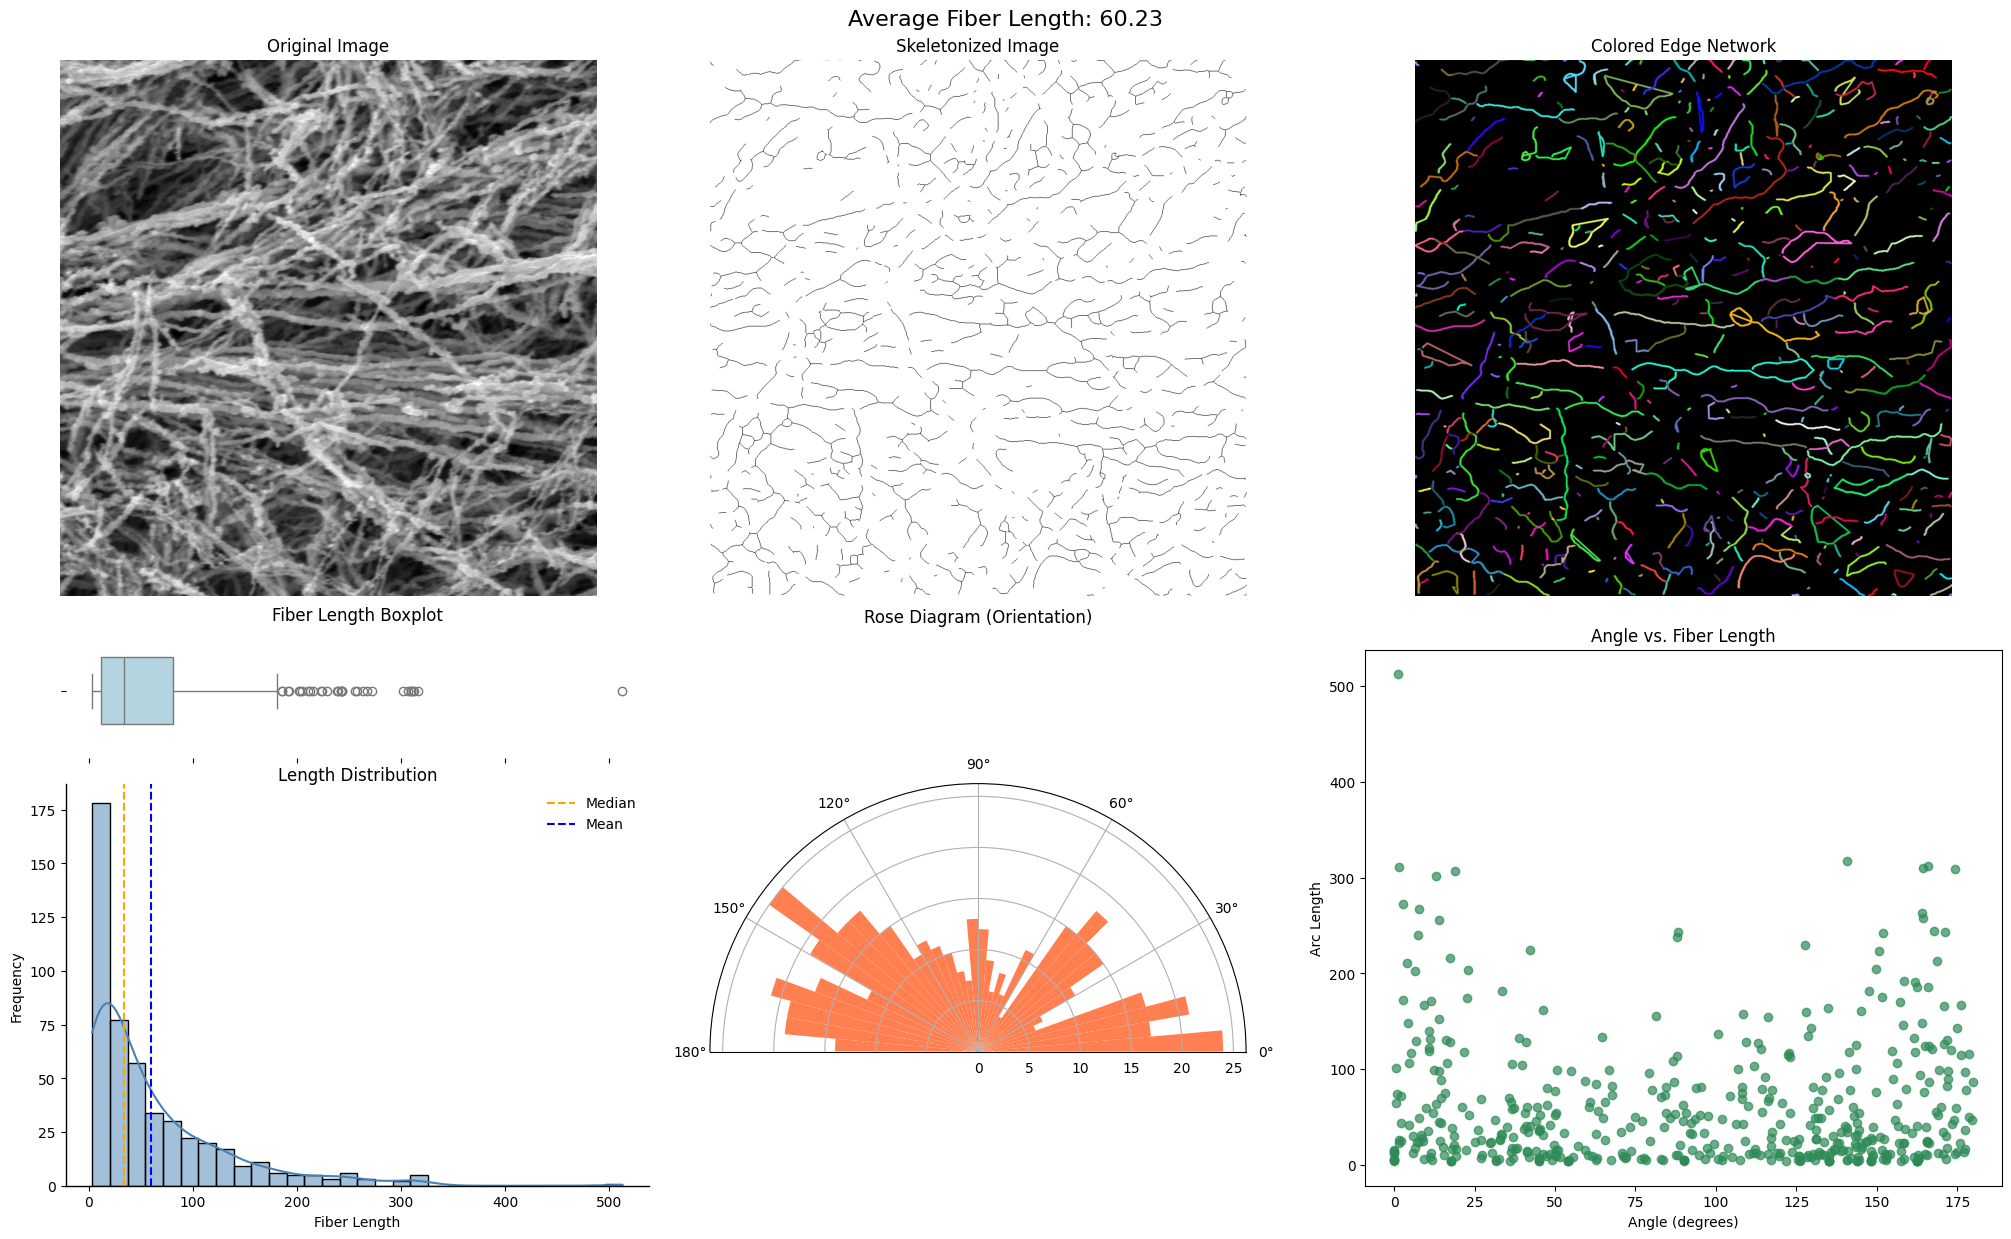

🎯 Fiber length analysis completed in 8.18s



In [6]:
url = 'https://github.com/lonespear/aerogel/raw/main/aerogel_co_50mM_magnet_0016.tif'
resp = urllib.request.urlopen(url)
image_array = np.asarray(bytearray(resp.read()), dtype=np.uint8)
base_img = cv2.imdecode(image_array, cv2.IMREAD_UNCHANGED)
img = fiberL(base_img[0:1000,0:1000], g_blur=25)
img.find_length()

🚀 Fiber length analysis started...

🧼 Preprocessing started...
  ⏳ Running anisotropic diffusion...
✅ Preprocessing completed in 14.43s

🔍 Detecting branches...
  🧠 Applying kernels...


  ⏳ Hit-or-Miss Kernels: 100%|██████████| 17/17 [00:00<00:00, 59.11it/s]


  📌 Found 2735 merged branch points.
  ✂️ Pruning small segments...


  ⏳ Contour Pruning: 100%|██████████| 9253/9253 [00:00<00:00, 707861.00it/s]

✅ Branch processing completed in 21.74s



✅ Association complete in 27.98s
🔧 Connecting edge segments...


  🔗 Pairing edges at branch points: 100%|██████████| 2726/2726 [00:02<00:00, 1055.28it/s]


✅ Edge connection completed in 2.59s

🔁 Merging close tips...
✅ Tip-to-tip merging done in 213.13s — final edge count: 4520


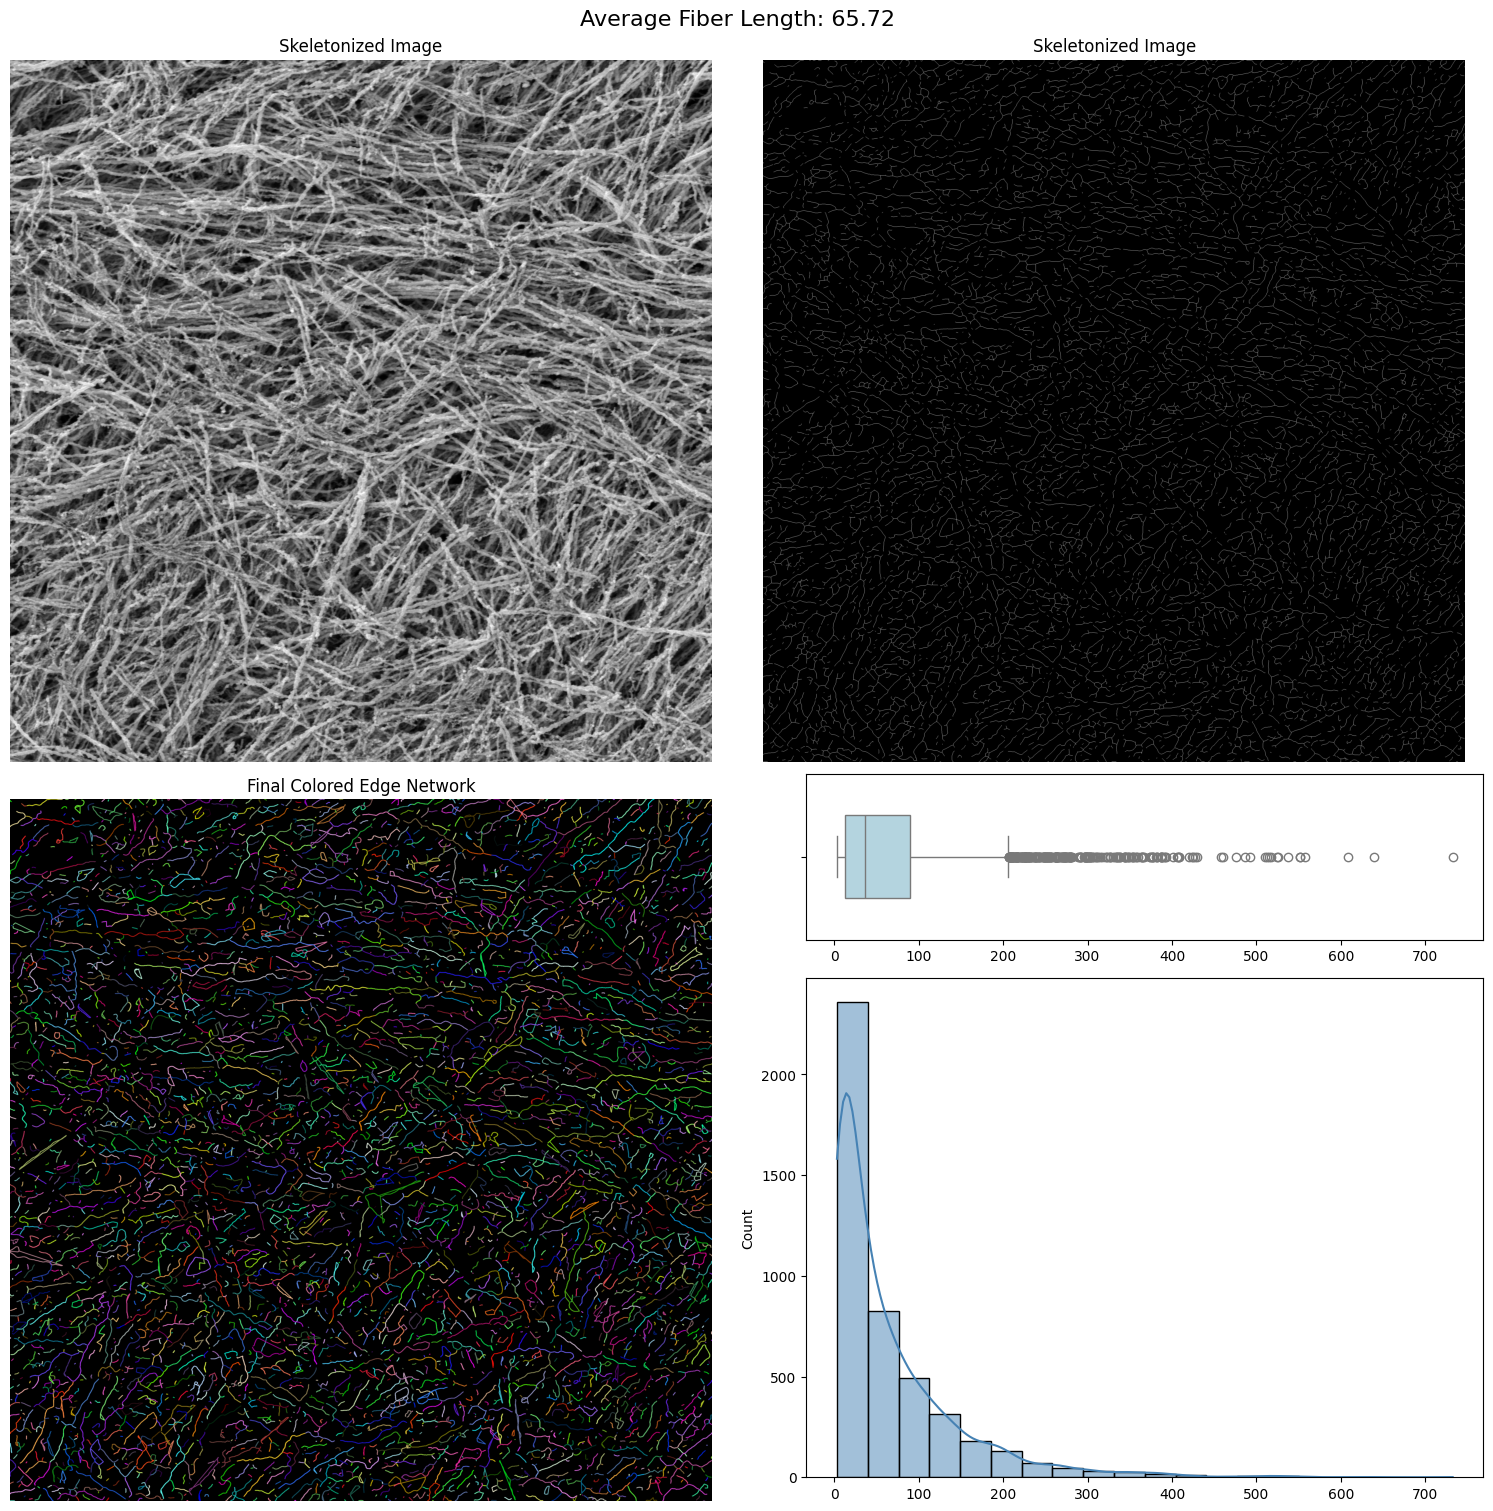

🎯 Fiber length analysis completed in 283.55s



In [100]:
url = 'https://github.com/lonespear/aerogel/raw/main/aerogel_co_50mM_magnet_0016.tif'
resp = urllib.request.urlopen(url)
image_array = np.asarray(bytearray(resp.read()), dtype=np.uint8)
base_img = cv2.imdecode(image_array, cv2.IMREAD_UNCHANGED)
img = fiberL(base_img[0:3000,0:3000], g_blur=25)
img.find_length()

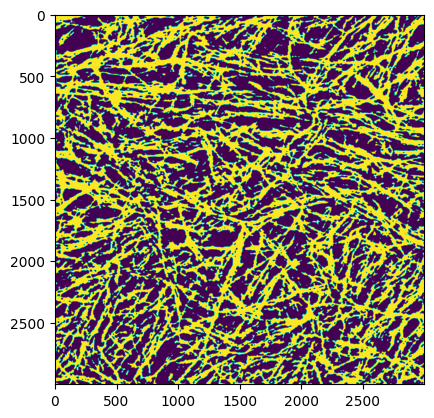

In [103]:
plt.imshow(img.binary_thresh)

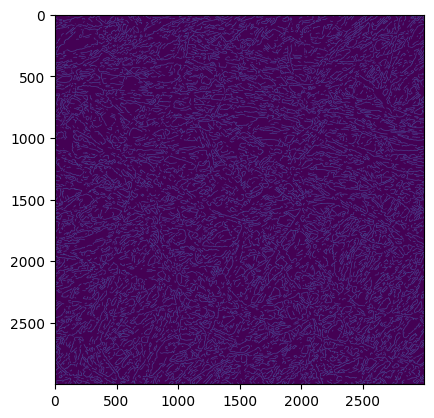

In [104]:
plt.imshow(img.binary_canny)

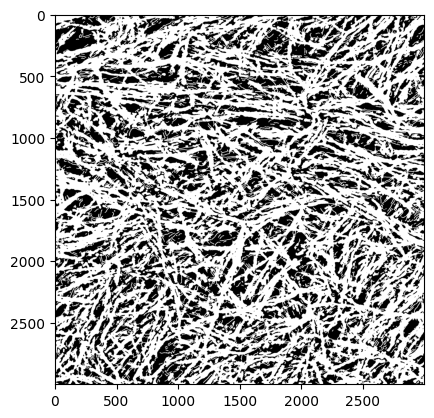

In [106]:
plt.imshow(img.binary_image, cmap='gray')

In [107]:
img.int_assoc

{2734: [13, 23],
 2733: [15, 53, 86],
 2731: [18, 24, 32, 47],
 2732: [19, 32, 52],
 2730: [25, 37, 54],
 2729: [26, 64, 145],
 2728: [35, 50, 74],
 2727: [39, 46, 235],
 2722: [40, 43, 59, 89, 97],
 2726: [41, 93],
 2724: [46, 51],
 2723: [48, 63, 119],
 2725: [51, 82, 127],
 2721: [60, 84, 88],
 2720: [62, 125, 135],
 2717: [65, 73, 124],
 2716: [67, 75, 163],
 2712: [68, 83, 104, 112],
 2718: [68, 84, 110],
 2719: [70, 71],
 2714: [74, 81, 105],
 2715: [76, 79, 139],
 2711: [85, 86, 147],
 2707: [89, 97, 149, 248],
 2708: [90, 99, 167],
 2713: [90, 113, 180],
 2710: [91, 95, 161],
 2706: [96, 120],
 2705: [98, 131, 190],
 2703: [100, 137, 140],
 2709: [101, 129],
 2704: [102, 104, 151],
 2701: [107, 108, 184, 191],
 2702: [109, 111, 177],
 2700: [110, 121, 128],
 2690: [112, 121, 141, 146, 246],
 2699: [113, 134, 138],
 2694: [117, 120, 156, 210],
 2698: [119, 153, 205],
 2697: [122, 142, 175],
 2696: [123, 176],
 2695: [124, 134, 212],
 2692: [127, 160, 171],
 2693: [130, 131, 234]

In [49]:
def sweep_tip_merge_params(fiber_obj, tip_dists=[15, 20, 25], cosines=[0.85, 0.90, 0.95], curvatures=[0.8, 0.85, 0.9]):
    results = []

    for td in tip_dists:
        for ct in cosines:
            for curv in curvatures:
                # Make a copy of the original edges
                original_edges = [np.copy(edge) for edge in fiber_obj.edges]

                # Run tip association
                fiber_obj.edges = [np.copy(edge) for edge in original_edges]  # Reset edges
                fiber_obj.tip_association(tip_distance_thresh=td, cos_thresh=ct, curvature_thresh=curv)

                # Compute average length
                lengths = [cv2.arcLength(e, closed=False) for e in fiber_obj.edges]
                avg = np.mean(lengths) if lengths else 0

                results.append({
                    "tip_dist": td,
                    "cos_thresh": ct,
                    "curv_thresh": curv,
                    "avg_length": avg,
                    "edge_count": len(lengths)
                })

    # Sort by average length descending
    results.sort(key=lambda x: x["avg_length"], reverse=True)

    print("🔍 Top 5 parameter combos by average fiber length:")
    for r in results[:5]:
        print(f"  🔹 dist={r['tip_dist']}, cos={r['cos_thresh']}, curv={r['curv_thresh']} → avg={r['avg_length']:.2f}, edges={r['edge_count']}")

    return results


In [50]:
# After running img.find_length(), run this:
sweep_tip_merge_params(img)


🔁 Merging close tips...
✅ Tip-to-tip merging done in 4.75s — final edge count: 483
🔁 Merging close tips...
✅ Tip-to-tip merging done in 3.21s — final edge count: 483
🔁 Merging close tips...
✅ Tip-to-tip merging done in 3.20s — final edge count: 483
🔁 Merging close tips...
✅ Tip-to-tip merging done in 3.18s — final edge count: 483
🔁 Merging close tips...
✅ Tip-to-tip merging done in 3.65s — final edge count: 483
🔁 Merging close tips...
✅ Tip-to-tip merging done in 4.20s — final edge count: 483
🔁 Merging close tips...
✅ Tip-to-tip merging done in 4.15s — final edge count: 483
🔁 Merging close tips...
✅ Tip-to-tip merging done in 4.31s — final edge count: 483
🔁 Merging close tips...
✅ Tip-to-tip merging done in 23.68s — final edge count: 483
🔁 Merging close tips...
✅ Tip-to-tip merging done in 26.11s — final edge count: 483
🔁 Merging close tips...
✅ Tip-to-tip merging done in 9.37s — final edge count: 483
🔁 Merging close tips...
✅ Tip-to-tip merging done in 19.10s — final edge count: 483
🔁

[{'tip_dist': 25,
  'cos_thresh': 0.85,
  'curv_thresh': 0.8,
  'avg_length': 63.2284121005344,
  'edge_count': 474},
 {'tip_dist': 25,
  'cos_thresh': 0.85,
  'curv_thresh': 0.85,
  'avg_length': 63.2284121005344,
  'edge_count': 474},
 {'tip_dist': 25,
  'cos_thresh': 0.85,
  'curv_thresh': 0.9,
  'avg_length': 63.2284121005344,
  'edge_count': 474},
 {'tip_dist': 25,
  'cos_thresh': 0.9,
  'curv_thresh': 0.8,
  'avg_length': 63.2284121005344,
  'edge_count': 474},
 {'tip_dist': 25,
  'cos_thresh': 0.9,
  'curv_thresh': 0.85,
  'avg_length': 63.2284121005344,
  'edge_count': 474},
 {'tip_dist': 25,
  'cos_thresh': 0.9,
  'curv_thresh': 0.9,
  'avg_length': 63.2284121005344,
  'edge_count': 474},
 {'tip_dist': 25,
  'cos_thresh': 0.95,
  'curv_thresh': 0.8,
  'avg_length': 63.2284121005344,
  'edge_count': 474},
 {'tip_dist': 25,
  'cos_thresh': 0.95,
  'curv_thresh': 0.85,
  'avg_length': 63.2284121005344,
  'edge_count': 474},
 {'tip_dist': 25,
  'cos_thresh': 0.95,
  'curv_thresh':

In [ ]:
import itertools
import pandas as pd

# Define parameter ranges
niter_vals = [10, 30, 50]
kappa_vals = [30, 50, 100]
gamma_vals = [0.1, 0.2]

thresh_1_vals = [100, 126, 150]
g_blur_vals = [9, 15, 25]
thresh_2_vals = [10, 15, 25]
ksize_vals = [3, 5]
min_prune_vals = [5, 10]
max_node_dist_vals = [10, 15]

# Create all combinations
param_combinations = list(itertools.product(
    niter_vals, kappa_vals, gamma_vals,
    thresh_1_vals, g_blur_vals, thresh_2_vals,
    ksize_vals, min_prune_vals, max_node_dist_vals
))

# Convert to DataFrame for readability
columns = [
    "niter", "kappa", "gamma",
    "thresh_1", "g_blur", "thresh_2",
    "ksize", "min_prune", "max_node_dist"
]
df_params = pd.DataFrame(param_combinations, columns=columns)

# Display for inspection
import ace_tools as tools; tools.display_dataframe_to_user(name="Parameter Sweep Combinations", dataframe=df_params)



🚀 Fiber length analysis started...

🧼 Preprocessing started...
  ⏳ Running anisotropic diffusion...
✅ Preprocessing completed in 0.12s

🔍 Detecting branches...
  🧠 Applying kernels...


  ⏳ Hit-or-Miss Kernels: 100%|██████████| 17/17 [00:00<00:00, 5669.78it/s]


  📌 Found 4 merged branch points.
  ✂️ Pruning small segments...


  ⏳ Contour Pruning: 100%|██████████| 13/13 [00:00<00:00, 13215.21it/s]


✅ Branch processing completed in 0.01s

✅ Association complete in 0.00s
🔧 Connecting edge segments...


  🔗 Pairing edges at branch points: 100%|██████████| 4/4 [00:00<00:00, 400.23it/s]

✅ Edge connection completed in 0.01s

🔁 Merging close tips...
⚠️ Not enough tip points to build KDTree.


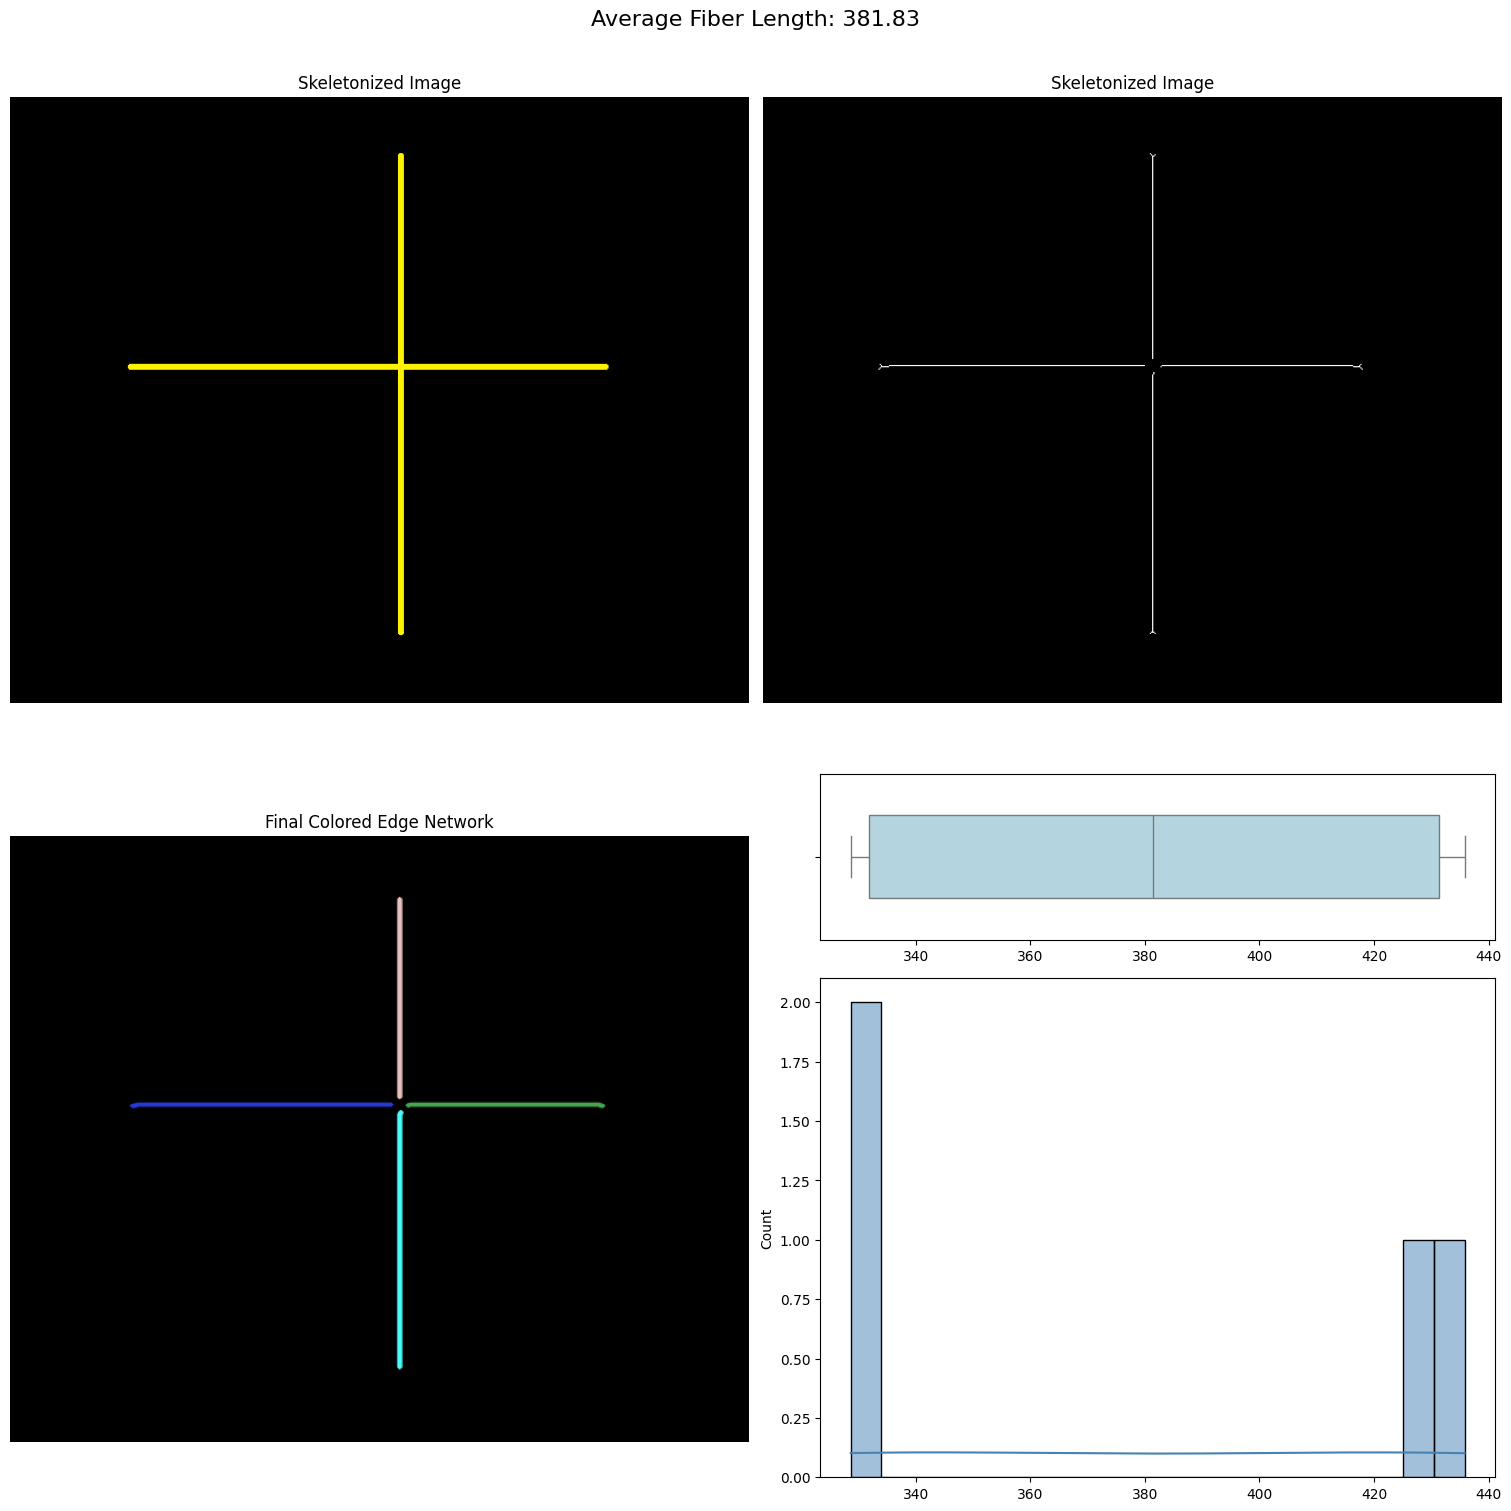

🎯 Fiber length analysis completed in 0.47s



In [111]:
base_img = plt.imread('test2.tif')
img = fiberL(base_img, g_blur=5)
img.find_length()

In [114]:
img.int_assoc

{3: [0], 2: [1], 1: [2], 0: [3]}

In [ ]:
img.tip_poi

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

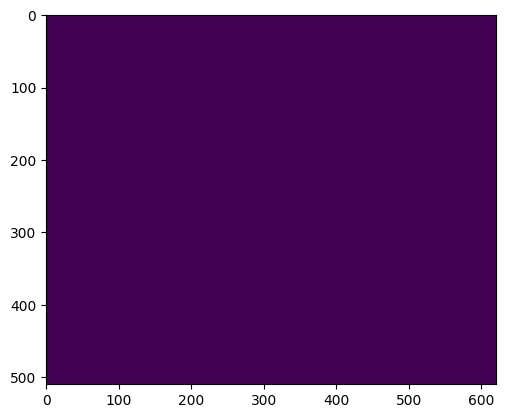

In [74]:
plt.imshow(img.bp)

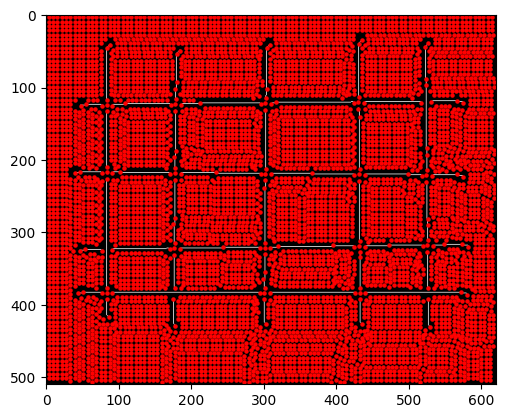

In [76]:
from skimage.feature import corner_harris, corner_peaks

# binary image from the skeleton
corners = corner_peaks(corner_harris(img.sk_image), min_distance=3)

# plot on top
plt.imshow(img.sk_image, cmap='gray')
plt.scatter(corners[:, 1], corners[:, 0], c='red', s=5)